## Compare cell locations from 2 STPT brains in the Common Coordinates Framework (CCF)

In [ ]:
!pip install --no-deps brainglobe-workflows  # avoid installing tensorflow
!pip install --no-deps -U cellfinder  # avoid installing tensorflow
!pip install cellfinder-core
!pip install -U brainreg

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage import exposure

In [2]:
def stretch_contrast(img):
    img_dtype = img.dtype
    dtype_max = np.iinfo(img_dtype).max
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    img = (img * dtype_max).astype(img_dtype)
    return img

### First brain

In [3]:
# https://api.brainimagelibrary.org/web/view?bildid=ace-cot-how
signal_channel = "/bil/data/54/78/54784078ebb39e72/P56_JL0131/STPT/stitchedImage_ch1/"
background_channel = "/bil/data/54/78/54784078ebb39e72/P56_JL0131/STPT/stitchedImage_ch1/"
output_location_brain1 = os.path.expanduser("~/workshop/brainmapper_out/brain1")

In [4]:
# !rm -r {output_location_brain1}

In [5]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain1} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-classification --ball-z-size 50

2024-04-19 11:03:48.570737: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:03:48.646901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:03:48.647637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 11:03:51.343985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-19 11:03:56 AM INFO     2024-04-19 11:03:56 AM - INFO -  ]8;id=906421;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py\fancylog.py]8;;\:]8;id=868669;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py#295\295]8;;

                       INFO     2024-04-19 11:04:09 AM - INFO -       ]8;id=676953;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/brainglobe_workflows/brainmapper/main.py\main.py]8;;\:]8;id=958773;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/brainglobe_workflows/brainmapper/main.py#99\99]8;;\
                                MainProcess main.py:99 - Finished.              
                                Total time taken: 0:00:13.006836                


In [6]:
from imlib.IO.cells import get_cells
all_detections = get_cells(os.path.join(output_location_brain1, 'points', "cells.xml"), cells_only=False)
all_detected_spots = []

for cell in all_detections:
    all_detected_spots.append([cell.z, cell.y, cell.x])

all_detected_spots = np.asarray(all_detected_spots)
np.save(os.path.join(output_location_brain1, 'points', "cells.npy"), all_detected_spots)

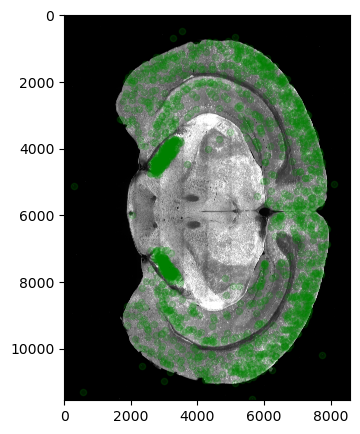

In [7]:
layer_to_show = 116
files = sorted(os.listdir(signal_channel))
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(tifffile.imread(os.path.join(signal_channel, files[layer_to_show]))), cmap="gray")
points = all_detected_spots[all_detected_spots[:,0] == layer_to_show]
plt.scatter(x=points[:,2], y=points[:,1], c='g', s=20, alpha=0.2)

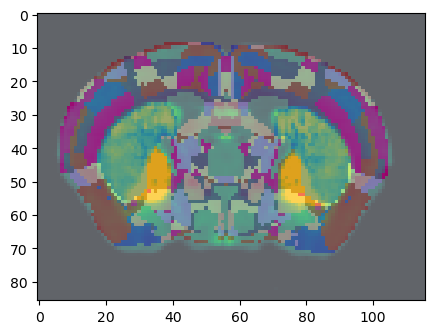

In [9]:
plot_layer = 60
downsampled_img = tifffile.imread(os.path.join(output_location_brain1, "registration/downsampled.tiff"))
boundary_img = tifffile.imread(os.path.join(output_location_brain1, "registration/registered_atlas.tiff"))
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(downsampled_img[plot_layer,:,:]))
values, indices = np.unique(boundary_img, return_inverse=True)
indices = indices.reshape(boundary_img.shape)
plt.imshow(indices[plot_layer,:,:], cmap="Accent", alpha=0.5)

In [10]:
from imlib.cells.cells import Cell
for cell in all_detections:
    cell.type = Cell.CELL

from imlib.IO.cells import save_cells
save_cells(all_detections, os.path.join(output_location_brain1, 'points', "cell_classification.xml"))

#### Transform points to the atlas space

In [11]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain1} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-detection --no-register --no-classification --ball-z-size 50

2024-04-19 11:06:16.410180: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:06:16.492257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:06:16.493004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 11:06:19.490122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-19 11:06:24 AM INFO     2024-04-19 11:06:24 AM - INFO -  ]8;id=933448;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py\fancylog.py]8;;\:]8;id=795906;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py#295\295]8;;

In [12]:
# cells_path = os.path.join(output_location, 'points', "points.npy")

# # Initialise brainrender scene
# scene = Scene()

# cells = np.load(cells_path)
# cells = cells[::100]

# # Create points actor
# cells = Points(cells, radius=45, colors="palegoldenrod", alpha=0.8)

# # Add cells
# scene.add(cells)

# scene.render()

In [13]:
# from vedo import Plotter  # <- this will be used to render an embedded scene 
# plt = Plotter()
# plt.show(*scene.renderables)

### Second brain

In [14]:
#https://api.brainimagelibrary.org/web/view?bildid=ace-dub-how
signal_channel = "/bil/data/b4/d4/b4d41a4bf7614449/P56_JL0081/STPT/stitchedImage_ch1/"
background_channel = "/bil/data/b4/d4/b4d41a4bf7614449/P56_JL0081/STPT/stitchedImage_ch1/"
output_location_brain2 = os.path.expanduser("~/workshop/brainmapper_out/brain2")

In [15]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain2} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-classification --no-analyse --no-figures --ball-z-size 50

2024-04-19 11:06:46.770704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:06:46.849547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:06:46.850279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 11:06:49.902736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-19 11:06:54 AM INFO     2024-04-19 11:06:54 AM - INFO -  ]8;id=473083;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py\fancylog.py]8;;\:]8;id=522933;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py#295\295]8;;

In [16]:
from imlib.IO.cells import get_cells
all_detections = get_cells(os.path.join(output_location_brain2, 'points', "cells.xml"), cells_only=False)
all_detected_spots = []

for cell in all_detections:
    all_detected_spots.append([cell.z, cell.y, cell.x])

all_detected_spots = np.asarray(all_detected_spots)
np.save(os.path.join(output_location_brain2, 'points', "cells.npy"), all_detected_spots)

In [17]:
from imlib.cells.cells import Cell
for cell in all_detections:
    cell.type = Cell.CELL
    from imlib.IO.cells import save_cells
save_cells(all_detections, os.path.join(output_location_brain2, 'points', "cell_classification.xml"))

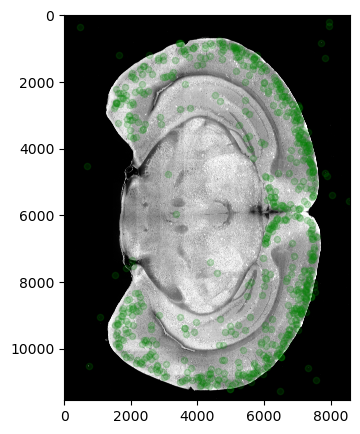

In [18]:
layer_to_show = 116
files = sorted(os.listdir(signal_channel))
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(tifffile.imread(os.path.join(signal_channel, files[layer_to_show]))), cmap="gray")
points = all_detected_spots[all_detected_spots[:,0] == layer_to_show]
plt.scatter(x=points[:,2], y=points[:,1], c='g', s=20, alpha=0.2)

In [19]:
downsampled_img = tifffile.imread(os.path.join(output_location_brain2, "registration/downsampled.tiff"))
boundary_img = tifffile.imread(os.path.join(output_location_brain2, "registration/registered_atlas.tiff"))

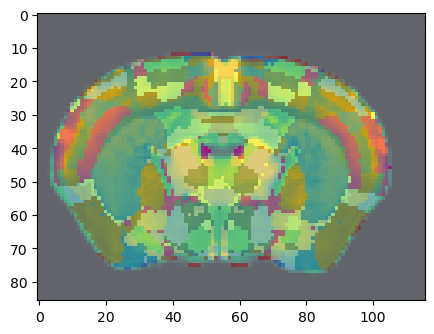

In [20]:
plot_layer = 60
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(stretch_contrast(downsampled_img[plot_layer,:,:]))
values, indices = np.unique(boundary_img, return_inverse=True)
indices = indices.reshape(boundary_img.shape)
plt.imshow(indices[plot_layer,:,:], cmap="Accent", alpha=0.5)

In [21]:
!brainmapper -s {signal_channel} -b {background_channel} -o {output_location_brain2} -v 50 1 1 --orientation pli --atlas allen_mouse_100um --no-detection --no-register --no-classification

2024-04-19 11:07:39.053963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:07:39.132056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 11:07:39.132781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 11:07:42.311754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-19 11:07:47 AM INFO     2024-04-19 11:07:47 AM - INFO -  ]8;id=67859;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py\fancylog.py]8;;\:]8;id=427573;file:///bil/users/noisysky/.local/lib/python3.9/site-packages/fancylog/fancylog.py#295\295]8;;

### Compare two brains in brainrender

In [22]:
from brainrender.scene import Scene
from brainrender.actors import Points

import vedo
vedo.settings.default_backend= 'k3d'

In [23]:
cells_path_brain1 = os.path.join(output_location_brain1, 'points', "points.npy")
cells_path_brain2 = os.path.join(output_location_brain2, 'points', "points.npy")

# Initialise brainrender scene
scene = Scene()

cells_brain1 = np.load(cells_path_brain1)
cells_brain1 = cells_brain1[::100]

cells_brain2 = np.load(cells_path_brain2)
cells_brain2 = cells_brain2[::100]

# Create points actor
cells1 = Points(cells_brain1, radius=45, colors="palegoldenrod", alpha=0.8)
cells2 = Points(cells_brain2, radius=45, colors="red", alpha=0.8)

# Add cells
scene.add(cells1)
scene.add(cells2)

scene.render()

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

In [24]:
from vedo import Plotter  # <- this will be used to render an embedded scene 
plt = Plotter()
plt.show(*scene.renderables)

/bil/users/noisysky/.local/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…

In [31]:
from IPython.display import IFrame

IFrame("./K3D-snapshot-1713541292486.html", 500, 500)

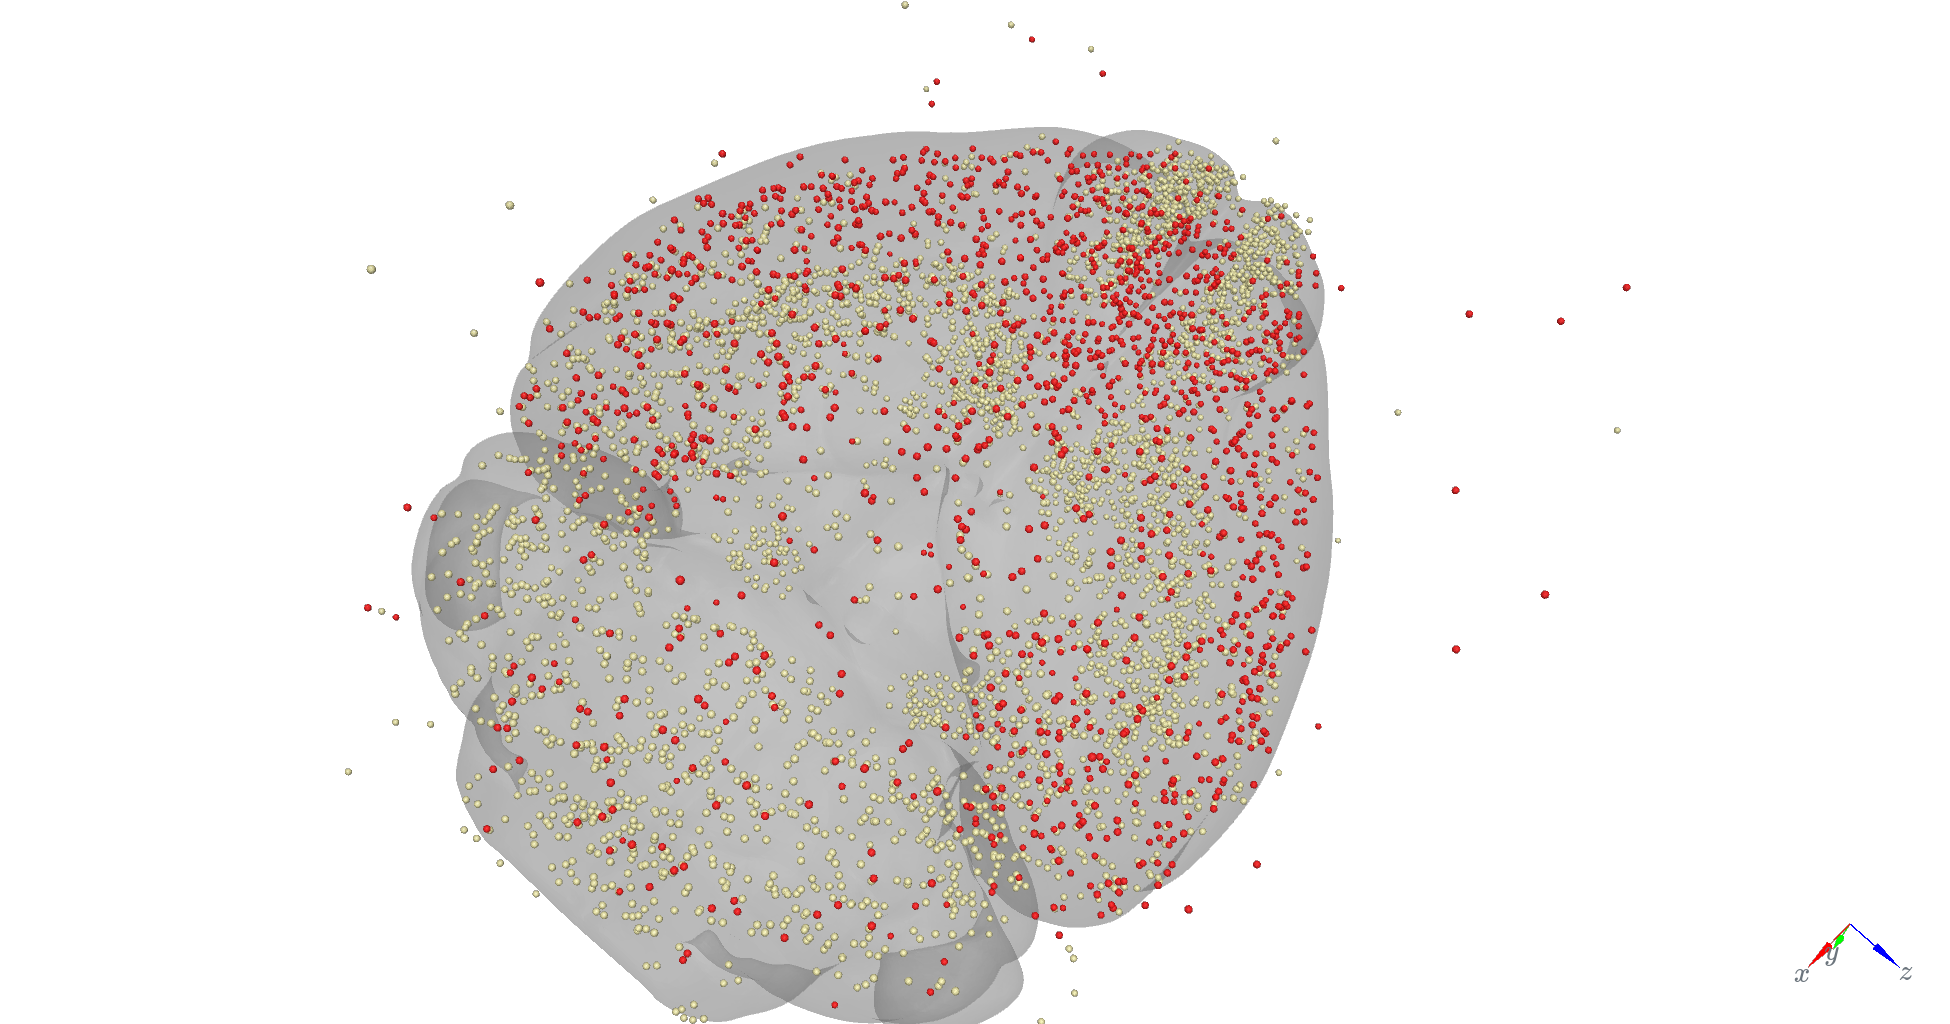

In [32]:
from IPython.display import Image
Image("./K3D-1713537763255.png")